In [1]:
## For debbugging
%load_ext autoreload

In [2]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))

In [3]:
## for debugging:
## for debugging:
%aimport mlp.kex
%aimport mlp.tree
%aimport mlp.plot
%autoreload 1
from mlp import kex
from mlp.tree import node_adj_mat, tag_network, tag_df_network
from mlp.plot import hv_net
from bokeh.palettes import Viridis10, Category10_6
import networkx as nx

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline


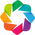

In [5]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=600 height=400]

In [6]:
data_dir = module_path/'data'/'mine_data'

df = pd.read_csv(data_dir/'mine_raw.csv')
df['BscStartDate'] = pd.to_datetime(df.BscStartDate)
df.head()

,BscStartDate,Asset,OriginalShorttext,PMType,Cost
0,2004-07-01,A,BUCKET WON'T OPEN,PM01,183.05
1,2005-03-20,A,L/H BUCKET CYL LEAKING.,PM01,407.40
2,2006-05-05,A,SWAP BUCKET,PM01,0.00
3,2006-07-11,A,FIT BUCKET TOOTH,PM01,0.00
4,2006-11-10,A,REFIT BUCKET TOOTH,PM01,1157.27


In [7]:
# merge and cleanse NLP-containing columns of the data
gs_nlp_select = kex.NLPSelect(columns = ['OriginalShorttext'])
raw_text = gs_nlp_select.transform(df)

### Build Vocab

In [8]:
study_fname = data_dir/'vocab_study'/'vocab_study_results.csv'

tex = kex.TokenExtractor()
toks = tex.fit_transform(raw_text)

tex2 = kex.TokenExtractor(ngram_range=(2, 2))  # new extractor (note 2-gram)
# define rules
NE_map = {'I I': 'I',  # two items makes one new item
          'I P': 'P I', 'I S': 'S I', 'P I': 'P I', 'S I': 'S I',  # order-free 
          'P P': 'X', 'P S': 'X', 'S P': 'X', 'S S': 'X'}  # redundancies
NE_types = 'IPSUX'
names=[f'{i}min' for i in range(10,70,10)]
files = sorted((data_dir/'vocab_study').glob('mine_public_raw_1Gram_[1-6]0mins.csv'))
if not study_fname.is_file():
    study_df = pd.DataFrame(index=df.index)
    for n,file in enumerate(files):
        print(str(file))
        vocab = kex.generate_vocabulary_df(tex, init=file)
        # do 1-grams
        tags_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)
        
#         ######

#         ########
        
        # do statistics
        tag_pct, tag_comp, tag_empt = kex._get_tag_completeness(tags_df)
        study_df[names[n]] = tag_pct
    study_df.to_csv(study_fname)
else: 
    study_df = pd.read_csv(study_fname, index_col=0)

study_df.head()

,10min,20min,30min,40min,50min,60min
0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0


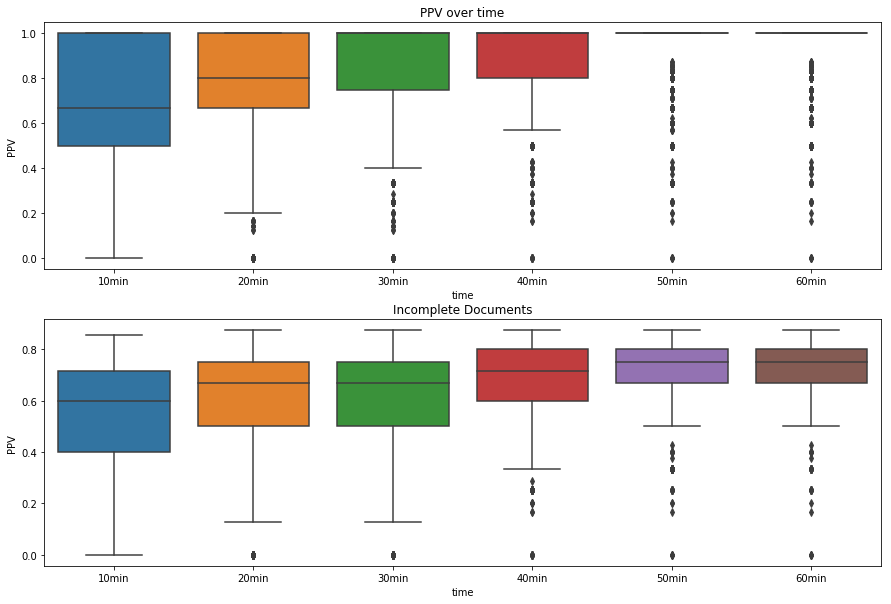

In [9]:
study_long = pd.melt(study_df, var_name="time", value_name='PPV').dropna()
study_long['time_val'] = study_long.time.str.replace('min','').astype(float)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.set_title('PPV over time')
sns.boxplot("time", y="PPV", data=study_long, ax=ax)
ax2 = fig.add_subplot(212)
ax2.set_title('Incomplete Documents')
sns.boxplot("time", y="PPV", data=study_long[study_long.PPV!=1], ax=ax2)

# sns.violinplot()

In [10]:
#now the good stuff
vocab_fname = data_dir/'vocab_study'/'mine_public_raw_1Gram_1grams-60mins-2grams-20mins.csv'
vocab = kex.generate_vocabulary_df(tex, init=vocab_fname)
tags_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)


replaced_text = kex.token_to_alias(raw_text, vocab)  # raw_text, with token-->alias replacement
toks2 = tex2.fit_transform(replaced_text)

#make 2-gram dictionary
vocab2_fname = data_dir/'vocab_study'/'mine_public_raw_nGram_1grams-60mins-2grams-20mins.csv'
vocab2 = kex.generate_vocabulary_df(tex2, init=vocab2_fname)

# extract 2-gram tags from cleaned text
tags2_df = kex.tag_extractor(tex2, replaced_text, vocab_df=vocab2)

## experimental: we need [item_item action] 2-grams, so let's use 2-gram Items for a 3rd pass...
# tex3 = kex.TokenExtractor(ngram_range(2,2))
# replaced_text2 = kex.token_to_alias(raw_text, vocab.join(vocab2))

intialized successfully!
intialized successfully!


HBox(children=(IntProgress(value=0, description='Category Loop', max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=860), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P token loop', max=53), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S token loop', max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, description='U token loop', max=68), HTML(value='')))

HBox(children=(IntProgress(value=0, description='X token loop', max=9), HTML(value='')))


intialized successfully!
intialized successfully!


HBox(children=(IntProgress(value=0, description='Category Loop', max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=1577), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=1846), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P token loop', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P I token loop', max=817), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S token loop', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S I token loop', max=584), HTML(value='')))

HBox(children=(IntProgress(value=0, description='X token loop', max=170), HTML(value='')))

In [16]:
## experimental: we need [item_item action] 2-grams, so let's use 2-gram Items for a 3rd pass...
tex3 = kex.TokenExtractor(ngram_range=(2,2))
mask = (vocab2.NE=='I') & (vocab2.alias!='')
vocab_combo = pd.concat([vocab, vocab2[mask]])
vocab_combo['score'] = 0

# keep just in case of duplicates
vocab_combo = vocab_combo.reset_index().drop_duplicates(subset=['tokens']).set_index('tokens')

replaced_text2 = kex.token_to_alias(replaced_text, vocab_combo)
# print(replaced_text2)
toks3 = tex3.fit_transform(replaced_text2)
# print(toks3)
# define rules
NE_map = {'I I': 'I',  # two items makes one new item
          'I P': 'P I', 'I S': 'S I', 'P I': 'P I', 'S I': 'S I',  # order-free 
          'P P': 'X', 'P S': 'X', 'S P': 'X', 'S S': 'X'}  # redundancies
NE_types = 'IPSUX'

#make 2-gram dictionary
vocab3 = kex.generate_vocabulary_df(tex3)
vocab3 = kex.ngram_automatch(vocab_combo, vocab3, NE_types, NE_map)

# extract 2-gram tags from cleaned text
tags3_df = kex.tag_extractor(tex3, replaced_text2, vocab_df=vocab3)

intialized successfully!


HBox(children=(IntProgress(value=0, description='Category Loop', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=1521), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=1689), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P I token loop', max=828), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S I token loop', max=810), HTML(value='')))

HBox(children=(IntProgress(value=0, description='X token loop', max=152), HTML(value='')))

In [17]:
# merge 1 and 2-grams.
tag_df = tags_df.join(tags3_df.drop(axis='columns', labels=tags_df.columns.levels[1].tolist(), level=1))
tags_read = kex._get_readable_tag_df(tag_df)
relation_df = tag_df.loc[:, ['P I', 'S I']]
tag_df = tag_df.loc[:, ['I', 'P', 'S', 'U', 'X', 'NA']]    
    

/home/tbsexton/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Extracted Keywords

Docs have at most 8 tokens (95th percentile)


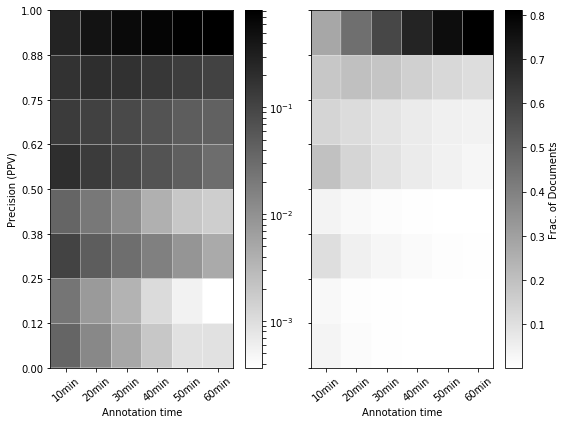

In [18]:
import matplotlib.cm as cm
nbins = int(np.percentile(tag_df.sum(axis=1), 95))
print(f'Docs have at most {nbins} tokens (95th percentile)')
H, x_edge, y_edge = np.histogram2d(study_long.time_val, study_long.PPV, bins=[6,nbins], normed=False)
H = H/len(df)
X, Y = np.meshgrid(x_edge, y_edge)
# city.plot(ax=ax, color='xkcd:slate')
# pcm = ax.pcolormesh(X, Y, H)
import matplotlib.colors as colors
fig, ax = plt.subplots(1, 2, figsize=(8,6), sharey=True)
# plt.figure()

pcm = ax[0].pcolor(X, Y, H.T ,cmap=cm.gray_r, 
                norm=colors.LogNorm(vmin=H.min(), 
                                    vmax=H.max()),
               edgecolors='white', linewidths=.2,)
ppv_labels = np.linspace(0,1,nbins+1)
ax[0].set_yticks(ppv_labels, [f'{i:.2f}' for i in ppv_labels])
ax[0].set_xticks(x_edge+50/12.)
ax[0].set_xticklabels( names, rotation=40)
# plt.Axes.set_xticklabels()
ax[0].set_xlim(10,60)
ax[0].set_xlabel('Annotation time')
ax[0].set_ylabel('Precision (PPV)')
# plt.title('Mean Calls/Day')
fig.colorbar(pcm, ax=ax[0])

pcm = ax[1].pcolor(X, Y, H.T ,cmap=cm.gray_r, 
#                 norm=colors.LogNorm(vmin=H.min(), 
#                                     vmax=H.max()),
               edgecolors='white', linewidths=.2,)
ppv_labels = np.linspace(0,1,nbins+1)
plt.yticks(ppv_labels, [f'{i:.2f}' for i in ppv_labels])
plt.xticks(x_edge+50/12., names, rotation=40)
ax[1].set_xlim(10,60)
ax[1].set_xlabel('Annotation time')
# ax[1].set_ylabel('Precision (PPV)')
# plt.title('Mean Calls/Day')
fig.colorbar(pcm, ax=ax[1], label='Frac. of Documents')
plt.tight_layout()

In [19]:
tags_read.join(df[['OriginalShorttext']]).sample(10)

,I,P,P I,S,S I,U,X,OriginalShorttext
2699,"right_hand, drive, final, right_hand_final drive",,,"refill, flush",refill right_hand_final,,,Flush and refill RH final drive
4161,"left_hand, motor, text, seal, travel, left_han...",leak,"leak text, motor_seal leak",,,,,lh travel motor seal leaking (see text)
675,air,,,"changeout, cleaners","air cleaners, changeout air",,,change air cleaners
197,"bucket, plate",wear,"wear plate, bucket wear",repair,repair bucket,,,REPAIR BUCKET WEAR PLATES
4943,"right_hand, boom, walkway, right_hand boom",broken,walkway broken,,,,,WALKWAY BROKEN - RH SIDE OF BOOM
5252,air,blowing,"blowing hot_air, air blowing",check,check air,hot,,check air con (blowing hot air)
5000,"boom, light, light boom",stick,boom stick,,,,extra,Fit extra lights to boom and stick
2980,"engine, lube, right_hand, starter, lube starter",,,replace,replace right_hand_engine,pre,,REPLACE RH ENG PRE-LUBE STARTER
5378,"air, pressure, pressure air",,,,,high,,high pressure R / H air. con
1470,"engine, left_hand, pipe, coolant, left_hand_en...","overflow, split","coolant overflow, split pipe",,,,,SPLIT PIPE ON LH ENG COOLANT OVERFLOW


In [21]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  1767
total tags:  492


,NE,alias,notes,score
NE,,,,
,1,3,2,766
I,1,317,19,585
P,1,53,6,119
S,1,42,2,95
U,1,68,57,92
X,1,9,1,9


Tag completeness: 0.87 +/- 0.19
Complete Docs: 3580, or 65.27%
Empty Docs: 48, or 0.88%


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


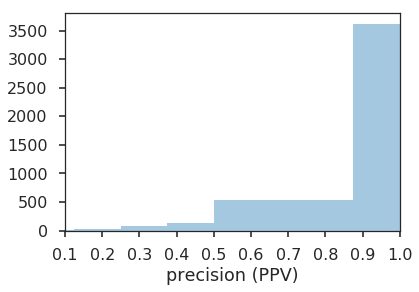

In [22]:
# tag-completeness of work-orders?
tag_pct, tag_comp, tag_empt = kex._get_tag_completeness(tag_df)

with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    sns.distplot(tag_pct.dropna(), 
                 kde=False, bins=nbins, 
                 kde_kws={'cut':0})
    plt.xlim(0.1, 1.0)
    plt.xlabel('precision (PPV)')


# WORK BELOW HERE
## Survival Analysis

### Rules-Based

In [23]:

df_clean = pd.read_csv(data_dir/'mine_clean.csv')
df_clean['SuspSugg'] = pd.to_numeric(df_clean['SuspSugg'], errors='coerce')
df_clean.dropna(subset=['RunningTime', 'SuspSugg'], inplace=True)
df_clean['BscStartDate'] = pd.to_datetime(df_clean.BscStartDate)
df_clean.shape

(5288, 17)

In [24]:
df_clean.sort_values('BscStartDate').head(10)

,BscStartDate,Asset,OriginalShorttext,PMType,Cost,RunningTime,MajorSystem,Part,Action,Variant,FM,Location,Comments,FuncLocation,SuspSugg,Rule,Unnamed: 16
8,2001-07-19,B,REPLACE LIP,PM01,1251.52,7.0,Bucket,NaN,Replace,2V,NaN,NaN,NaN,Bucket,0.0,Rule_1_3_78_383_384,NaN
1820,2001-09-01,B,OIL LEAK L/H TRACK TENSIONER.,PM01,0.00,3.0,Hydraulic System,Track,Minor Maint,18,Leak,Left,NaN,Power Train - Transmission,0.0,Rule_1_3_52_289_347_425_500,NaN
1821,2001-09-04,B,BAD SOS METAL IN OIL,PM01,0.00,3.0,Hydraulic System,Slew Gearbox,NaN,NaN,Contamination,NaN,NaN,Sprocket/Drive Compartment Right,0.0,Rule_1_3_52_303_409,NaN
5253,2001-09-05,B,REPLACE AIRCONDITIONER BELTS,PM01,0.00,23.0,NaN,Air Conditioning,Replace,2V,NaN,NaN,NaN,Air Conditioning System,0.0,Rule_1_3_224_227_383_384,NaN
3701,2001-09-05,B,REPLACE CLAMPS ON CLAM PIPES,PM01,0.00,28.0,NaN,Mount,Replace,2V,NaN,NaN,NaN,Oil - Hydraulic,0.0,Rule_1_3_92_181_383_384,NaN
1167,2001-09-05,B,REPLACE RHS FAN BELT TENSIONER PULLEY,PM01,82.09,0.0,NaN,Fan,Minor Maint_Replace,2V,NaN,Right,NaN,+Cooling System,0.0,Rule_1_3_125_347_383_384_509,NaN
1168,2001-09-11,B,replace fan belt,PM01,0.00,6.0,NaN,Fan,Replace,2V,NaN,NaN,NaN,+Cooling System,0.0,Rule_1_3_125_383_384,NaN
644,2001-09-15,B,replace heads on lhs eng,PM01,0.00,33.0,Engine,NaN,Replace,2V,NaN,Left,NaN,Engine Left Cylinder Heads,0.0,Rule_1_3_25_383_384_499,NaN
4583,2001-09-26,B,REPAIR CABIN DOOR FALLING OFF.,PM01,0.00,27.0,NaN,Drivers Cabin,Repair,1,NaN,NaN,NaN,Operators Cabin,0.0,Rule_1_3_251_284_357,NaN
9,2001-10-01,B,rebuild lip #3,PM01,0.00,74.0,Bucket,NaN,Repair,5,NaN,NaN,NaN,Bucket Clam (Lip),0.0,Rule_1_3_78_362,NaN


0.060 0.833
n=519, number of events=513

          coef  se(coef)  lower 0.95  upper 0.95
lambda_ 0.0598    0.0033      0.0532      0.0663
rho_    0.8327    0.0260      0.7816      0.8837
transform: β=0.83	η=16.73


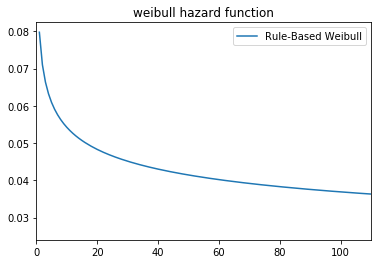

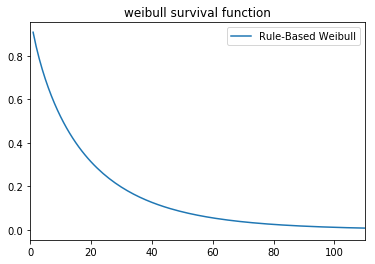

In [108]:
from lifelines import WeibullFitter, ExponentialFitter, KaplanMeierFitter
mask = (df_clean.MajorSystem =='Bucket')
# mask=df_clean.index
def mask_to_ETclean(df_clean, mask, fill_null=1.):
    filter_df = df_clean.loc[mask]
    g = filter_df.sort_values('BscStartDate').groupby('Asset')
    T = g['BscStartDate'].transform(pd.Series.diff).dt.days
#     T.loc[(T<=0.)|(T.isna())] = fill_null
    E = (~filter_df['SuspSugg'].astype(bool)).astype(int)
    return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]

T, E = mask_to_ETclean(df_clean, mask)
wf = WeibullFitter()
wf.fit(T, E, label='Rule-Based Weibull')
print('{:.3f}'.format(wf.lambda_), '{:.3f}'.format(wf.rho_))
wf.print_summary()
wf.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wf.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wf.rho_:.2f}\tη={1/wf.lambda_:.2f}')

9.0

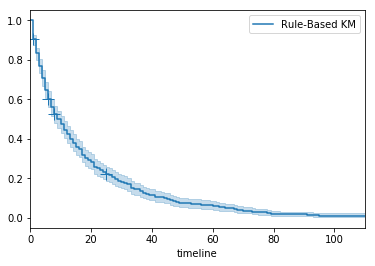

In [107]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Rule-Based KM')
# kmf.survival_function_.plot()
kmf.plot(show_censors=True)
plt.xlim(0,110)
kmf.median_

MTTF: 
Weib 	 10.77
KM 	9.00


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


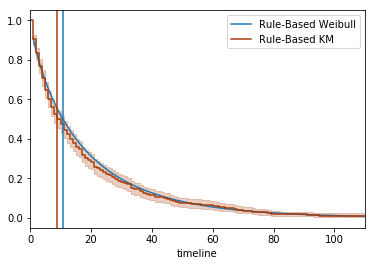

In [109]:
f,ax = plt.subplots()
wf.survival_function_.plot(ax=ax)
kmf.plot(ax=ax, color='xkcd:rust')
ax.axvline(wf.median_)
ax.axvline(kmf.median_, color='xkcd:rust')
ax.set_xlim(0,110)
print(f'MTTF: \nWeib \t {wf.median_:.2f}\nKM \t{kmf.median_:.2f}')

In [82]:
wf.survival_function_at_times(30)

0.19672108202105731

### Tag-Based

In [40]:
df.sort_values('BscStartDate').head(10)

,BscStartDate,Asset,OriginalShorttext,PMType,Cost
4331,2001-07-05,B,replace lhs track adjuster & acumulator,PM01,6169.05
7,2001-07-12,B,REPLACE MISSING LIP TIPS,PM01,1281.36
8,2001-07-19,B,REPLACE LIP,PM01,1251.52
1237,2001-07-19,B,REPLACE FUEL SOLENOID,PM01,222.17
3700,2001-08-08,B,re-mount grease tank,PM01,0.00
2810,2001-08-08,B,re-mount grease tank,PM01,0.00
643,2001-08-13,B,scope wter leak on rhs engine,PM01,0.00
5252,2001-08-13,B,check air con (blowing hot air),PM01,0.00
3935,2001-08-14,B,boom control valve lines & fittings leak,PM01,0.00
1819,2001-08-29,B,REPAIR HYD LEAKS ON TRACK TENSIONERS,PM01,0.00


0.061 0.822
n=589, number of events=564

          coef  se(coef)  lower 0.95  upper 0.95
lambda_ 0.0610    0.0033      0.0545      0.0674
rho_    0.8219    0.0247      0.7735      0.8703
transform: β=0.82	η=16.40


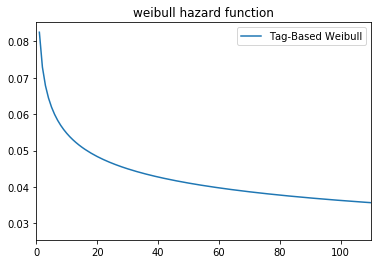

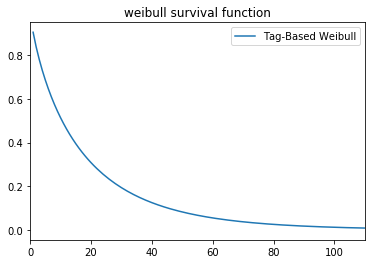

In [228]:
# from lifelines import WeibullFitter, ExponentialFitter, KaplanMeierFitter
# mask = (tag_df.I['bucket']>0)|(tag_df.I['tooth']>0)|(tag_df.I['lip']>0)
mask = tag_df.I[['bucket', 'tooth', 'lip', 'pin']].sum(axis=1)>0
# mask=df_clean.index
def mask_to_ETraw(df_clean, mask, fill_null=1.):
    filter_df = df_clean.loc[mask]
    g = filter_df.sort_values('BscStartDate').groupby('Asset')
    T = g['BscStartDate'].transform(pd.Series.diff).dt.days
    T_defined = (T>0.)|T.notna()
    T = T[T_defined]
    # assume censored when parts replaced (changeout)
    E = (~(tag_df.S.changeout>0)).astype(int)[mask]
    E = E[T_defined]
    return T.loc[~((T<=0.)|(T.isna()))], E.loc[~((T<=0.)|(T.isna()))]

T, E = mask_to_ETraw(df, mask)
wfT = WeibullFitter()
wfT.fit(T, E, label='Tag-Based Weibull')
print('{:.3f}'.format(wfT.lambda_), '{:.3f}'.format(wfT.rho_))
wfT.print_summary()
wfT.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wfT.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wfT.rho_:.2f}\tη={1/wfT.lambda_:.2f}')

9.0

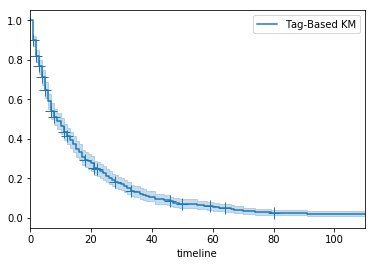

In [229]:
kmfT = KaplanMeierFitter()
kmfT.fit(T, event_observed=E, label='Tag-Based KM')
# kmf.survival_function_.plot()
kmfT.plot(show_censors=True)
plt.xlim(0,110)
kmfT.median_

MTTF: 
Weib 	 10.50
KM 	9.00


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


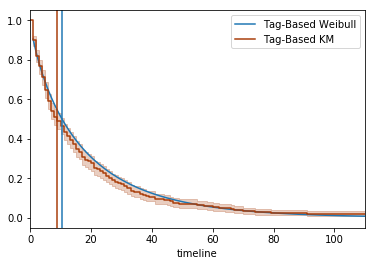

In [230]:
f,ax = plt.subplots()
wfT.survival_function_.plot(ax=ax)
kmfT.plot(ax=ax, color='xkcd:rust')
ax.axvline(wfT.median_)
ax.axvline(kmfT.median_, color='xkcd:rust')
ax.set_xlim(0,110)
print(f'MTTF: \nWeib \t {wfT.median_:.2f}\nKM \t{kmfT.median_:.2f}')

In [231]:
wfT.survival_function_at_times(30)

0.19349456917269223

### Comparison

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


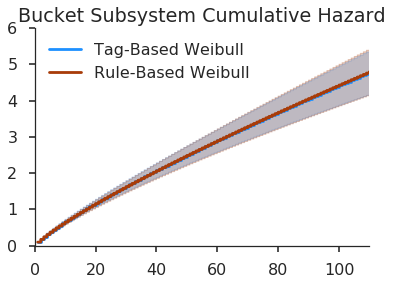

In [232]:
with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='poster') as context:
    f,ax = plt.subplots()
    wfT.plot(ax=ax, color='dodgerblue')
    wf.plot(ax=ax, color='xkcd:rust')
    ax.set_xlim(0,110)
    ax.set_ylim(0,6)
    ax.set_title("Bucket Subsystem Cumulative Hazard")
    sns.despine()

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


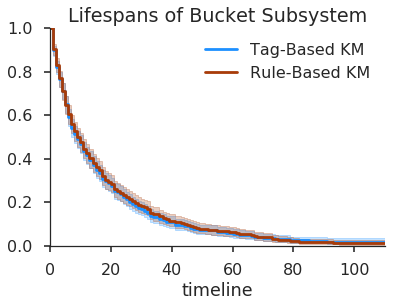

In [233]:

with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='poster') as context:
    f,ax = plt.subplots()
    kmfT.plot(ax=ax, color='dodgerblue')
    kmf.plot(ax=ax, color='xkcd:rust')
    ax.set_xlim(0,110)
    ax.set_ylim(0,1)
    ax.set_title("Lifespans of Bucket Subsystem")
    sns.despine()


This next one give you an idea of the differences better. using a log-transform. the tags under-estimate death rates a little in the 80-130 day range, probably because there's a failure mode not captured by the [bucket, lip, tooth] tags (because it's rare).

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


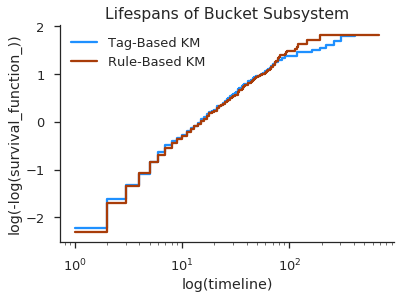

In [234]:

with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='talk') as context:
    f,ax = plt.subplots()
    kmfT.plot_loglogs(ax=ax, color='dodgerblue')
    kmf.plot_loglogs(ax=ax, color='xkcd:rust')
#     ax.set_xlim(0,110)
#     ax.set_ylim(0,1)
    ax.set_title("Lifespans of Bucket Subsystem")
    sns.despine()

In [145]:
kmfT.subtract(kmf)

,Rule-Based KM,Tag-Based KM
timeline,,
0.0,NaN,NaN
1.0,NaN,NaN
2.0,NaN,NaN
3.0,NaN,NaN
4.0,NaN,NaN
5.0,NaN,NaN
6.0,NaN,NaN
7.0,NaN,NaN
8.0,NaN,NaN


## Tag Cool Stuff

In [146]:
colors = {
            'P':'#C0504D',
            'S':'#7ABC32',
            'I':'#4F81BD',
            'U':'#ffc000',
            'NA':'gray',
            'X':'black'
        }

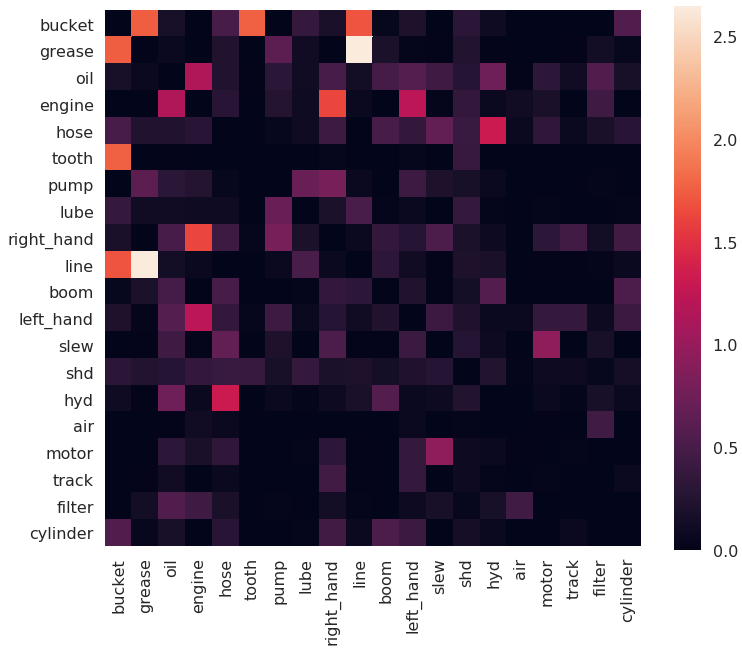

In [196]:
tag_similarity = mlp.tree.node_adj_mat(tag_df["I"])
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.heatmap(200*tag_similarity.iloc[:20,:20], square=True)

In [197]:
D = mlp.tree.heymann_taxonomy(tag_similarity, dynamic=False, verbose=True, tau=9e-4)

  8%|▊         | 148/1838 [00:00<00:02, 735.96it/s]

right_hand


100%|██████████| 1838/1838 [00:21<00:00, 86.83it/s] 

right_hand
['bolts', 'text', 'rear', 'cover', 'gauge', 'rf', 'water', 'sensor', 'plate', 'outer', 'guard', 'handrail', 'sender', 'lower', 'housing', 'wire', 'welding', 'retainer', 'compressor', 'pressuriser', 'starter', 'scope', 'new', 'gear', 'bracket', 'screen', 'cap', 'swing', 'latch', 'scv', 'window', 'press', 'link', 'inner', 'safety', 'manifold', 'solenoid', 'tube', 'supply', 'plug', 'gasket', 'air_conditioning', 'deck', 'p1', 'machine', 'lever', 'walkway', 'keeper', 'pilot', 'breather', 'hour', 'radio', 'murphy', 'frame', 'cavity', 'spline', 'handle', 'labor', 'boom_control valve', 'mcv', 'ladder', 'electrical', 'area', 'dipstick', 'joystick', 'head', 'unit', 'bung', 'lube_pump pto', 'wing', 'case_drain hose', 'tip', 'rod', 'pirtek', 'undercarriage', 'cw', 'assy', 'harness', 'arm', 'left_hand track_roller', 'suppression', 'pivot', 'shaft', 'chain', 'bcs', 'room', 'thermostat', 'inside', 'spare', 'accident', 'left_hand_slew motor', 'commercial', 'center', 'p3', 'wiper', 'pulley',

6


/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


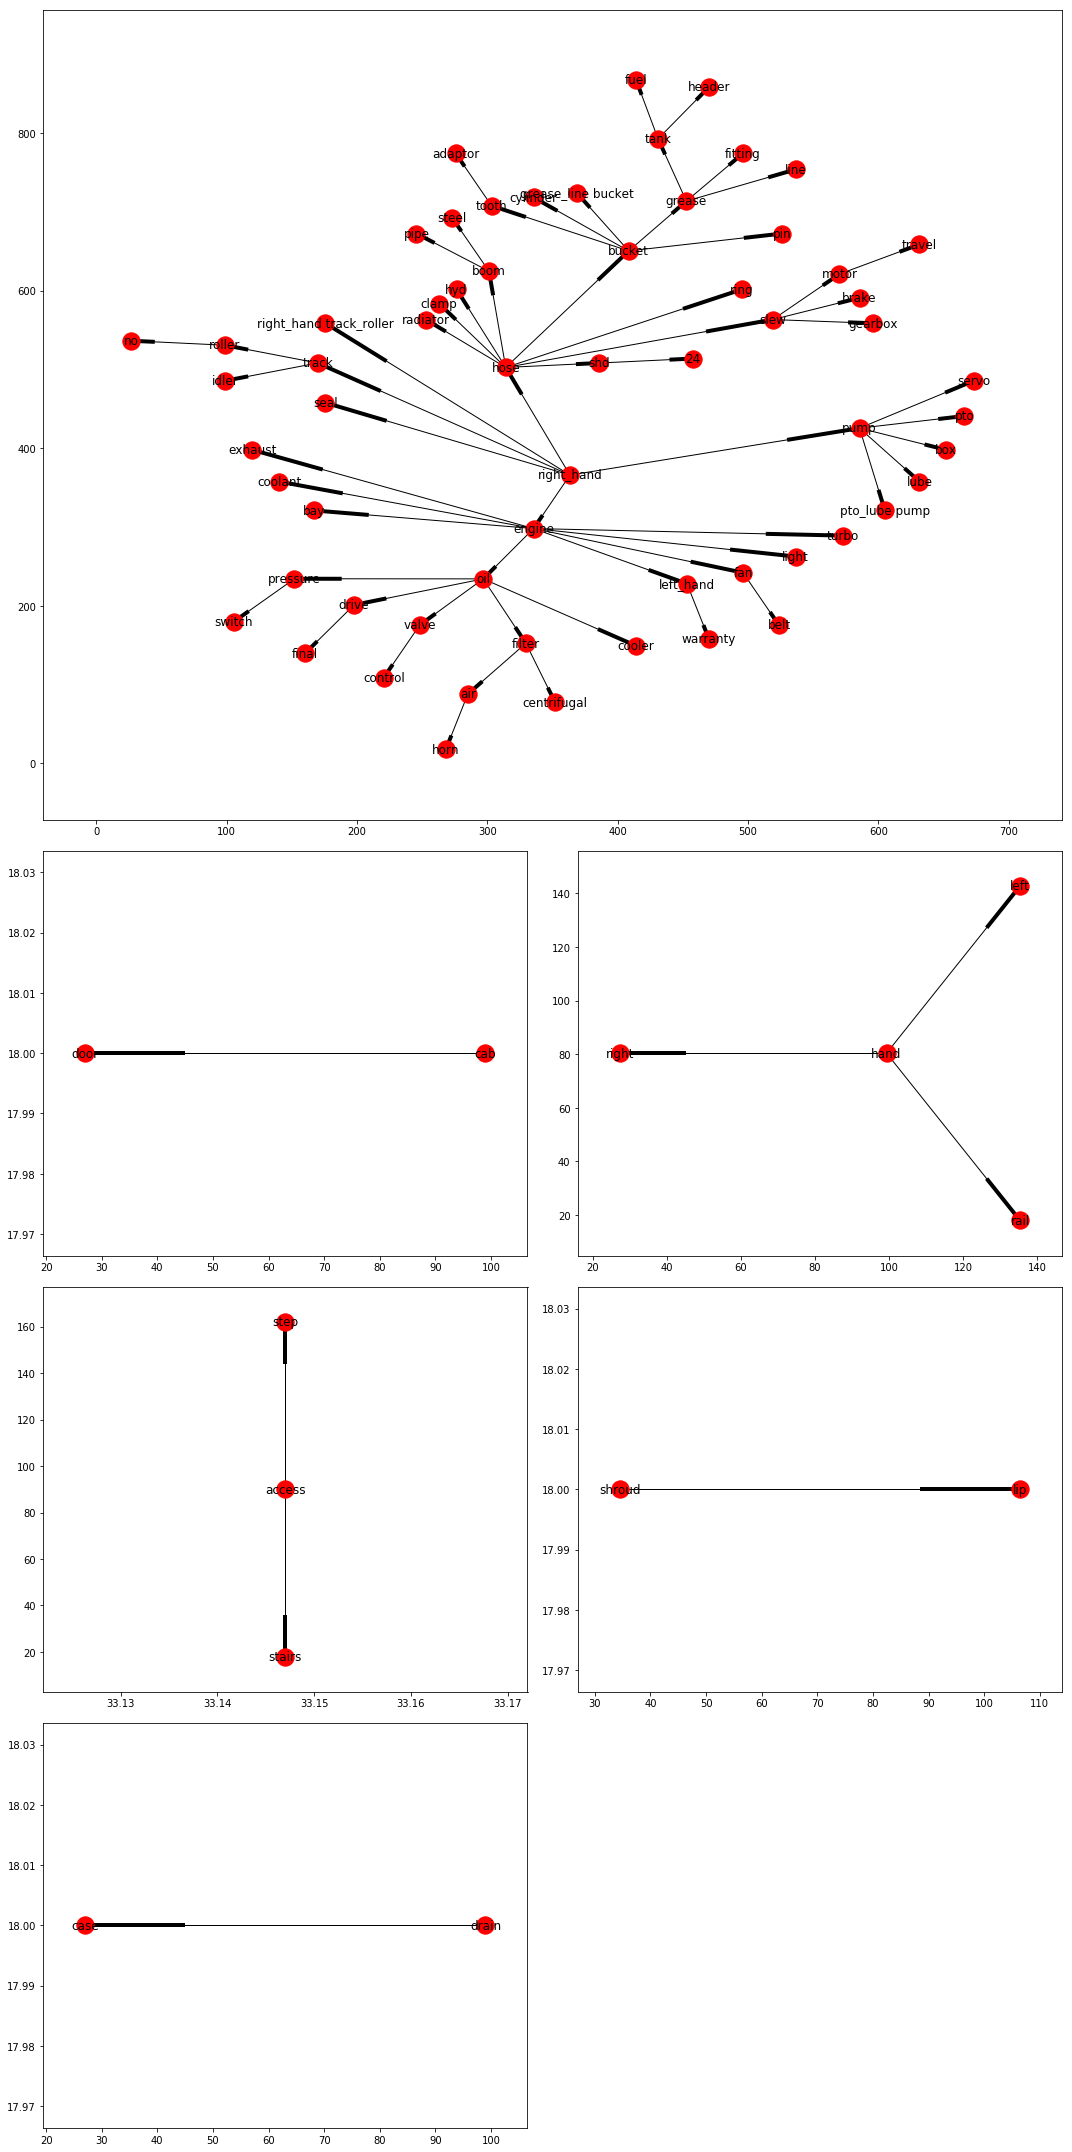

In [239]:
import matplotlib.gridspec as gridspec

subg = list(nx.weakly_connected_component_subgraphs(D))
fig = plt.figure(tight_layout=True, figsize=(15,30))
n_rows = 1+len(subg)//2+len(subg)%2
print(len(subg))
gs = gridspec.GridSpec(n_rows, 2, 
                       height_ratios=[2]+(n_rows-1)*[1])

for n, d in enumerate(subg):
    if n==0:
        ax = fig.add_subplot(gs[:n+1, :])
    else:
        ax = fig.add_subplot(gs[(n+1)//2, (n+1)%2])
    nx.draw_networkx(d, pos=nx.drawing.nx_pydot.pydot_layout(d, prog='twopi'), ax=ax)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


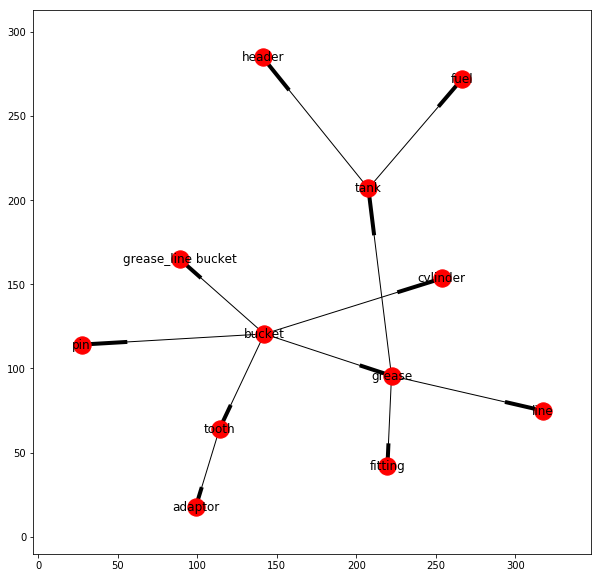

In [214]:
from networkx.algorithms.traversal.depth_first_search import dfs_tree, dfs_successors
subD = dfs_tree(D, 'bucket')

plt.figure(figsize=(10,10))
nx.draw_networkx(subD, pos=nx.drawing.nx_pydot.pydot_layout(subD, prog='fdp'))

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x720 with 0 Axes>

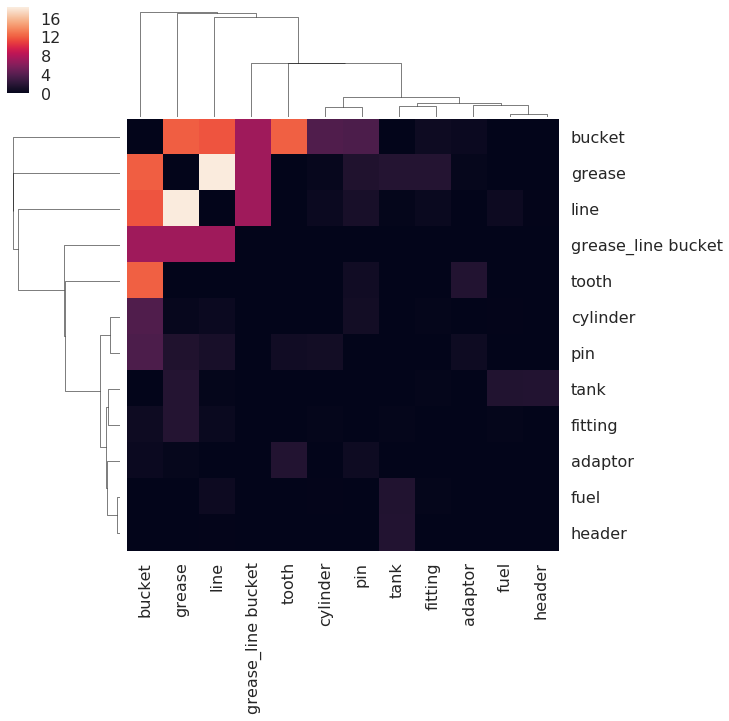

In [200]:
subsys_similarity = mlp.tree.node_adj_mat(tag_df.I[subD.nodes()])
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.clustermap(200*subsys_similarity, square=True)

0.101 0.879
n=1020, number of events=984

          coef  se(coef)  lower 0.95  upper 0.95
lambda_ 0.1008    0.0039      0.0933      0.1083
rho_    0.8793    0.0192      0.8417      0.9169
transform: β=0.88	η=9.92
MTTF: 
Weib 	 6.54
KM 	6.00


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


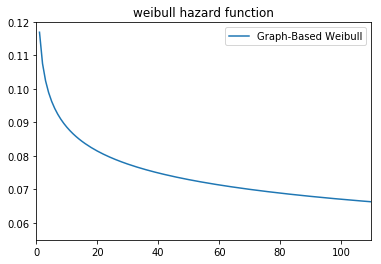

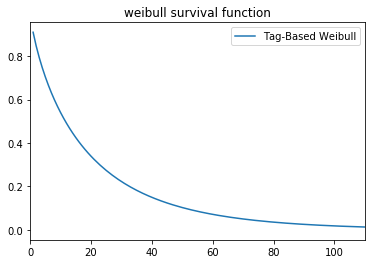

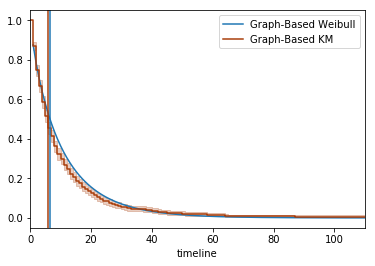

In [215]:
# tag_df.I[subD.nodes()].sum(axis=1)>0
# mask = tag_df.I[subD.nodes()].sum(axis=1)>0
mask = tag_df.I[list(nx.all_neighbors(D, 'bucket'))].sum(axis=1)>0

T, E = mask_to_ETraw(df, mask)
wfG = WeibullFitter()
wfG.fit(T, E, label='Graph-Based Weibull')
print('{:.3f}'.format(wfG.lambda_), '{:.3f}'.format(wfG.rho_))
wfG.print_summary()
wfG.hazard_.plot()
plt.title('weibull hazard function')
plt.xlim(0,110)

wfT.survival_function_.plot()
plt.xlim(0,110)
plt.title('weibull survival function')
print(f'transform: β={wfG.rho_:.2f}\tη={1/wfG.lambda_:.2f}')

kmfG = KaplanMeierFitter()
kmfG.fit(T, event_observed=E, label='Graph-Based KM')

f,ax = plt.subplots()
wfG.survival_function_.plot(ax=ax)
kmfG.plot(ax=ax, color='xkcd:rust')
ax.axvline(wfG.median_)
ax.axvline(kmfG.median_, color='xkcd:rust')
ax.set_xlim(0,110)
print(f'MTTF: \nWeib \t {wfG.median_:.2f}\nKM \t{kmfG.median_:.2f}')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


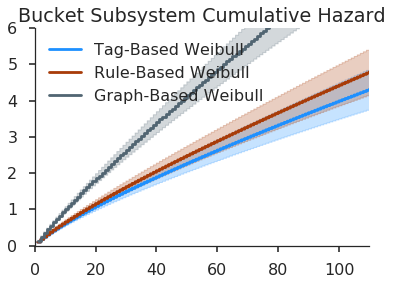

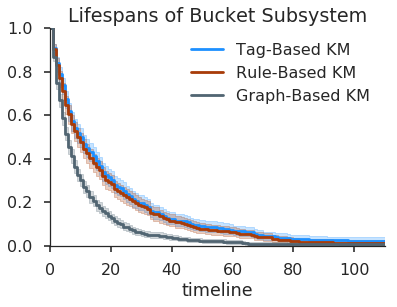

In [216]:
with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='poster') as context:
    f,ax = plt.subplots()
    wfT.plot(ax=ax, color='dodgerblue')
    wf.plot(ax=ax, color='xkcd:rust')
    wfG.plot(ax=ax, color='xkcd:slate')
    ax.set_xlim(0,110)
    ax.set_ylim(0,6)
    ax.set_title("Bucket Subsystem Cumulative Hazard")
    sns.despine()
    

with sns.axes_style(style='ticks') as style,\
    sns.plotting_context(context='poster') as context:
    f,ax = plt.subplots()
    kmfT.plot(ax=ax, color='dodgerblue')
    kmf.plot(ax=ax, color='xkcd:rust')
    kmfG.plot(ax=ax, color='xkcd:slate')
    ax.set_xlim(0,110)
    ax.set_ylim(0,1)
    ax.set_title("Lifespans of Bucket Subsystem")
    sns.despine()

In [235]:
from networkx.readwrite import json_graph

import json

subD = dfs_tree(D, 'right_hand')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'right_hand'), outfile)

In [236]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1400 - margin.right - margin.left,
    height = 900 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [237]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [238]:
f2(w=1500,h=1200)

### 2-grams

In [149]:
thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
clean_text.compute()[:10]

0          bucket will_not t open
1       l h bucket cylinder leak 
2                     swap bucket
3             repair bucket tooth
4             repair bucket tooth
5    repair loose bucket cylinder
6          replace 2 bucket tooth
7          replace absent lip tip
8                     replace lip
9                    build lip  3
dtype: object

In [169]:
from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)


['lube leak' 'lube line' 'position engine' ... 'shovel_no 1fitter' '01 10'
 '19 01']
attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


In [194]:
voc2 = tex2.annotation_assistant(data_dir/'2g_mine_vocab_test.csv')
NE_dict = vocab.reset_index()[['NE', 'alias']].dropna(subset=['alias']).drop_duplicates().set_index('alias').NE.fillna("U").to_dict()
# NE_dict = vocab.NE.fillna('U').to_dict()
# NE_dict.update(vocab.reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.fillna("U").to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)
# pd.DataFrame.drop_duplicates
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}

NE_map['I I'] = 'I'
NE_map['S I'] = 'S I'
NE_map['P I'] = 'P I'

NE_map['I S'] = 'S I'
NE_map['I P'] = 'P I'

NE_map['S S'] = 'X'
NE_map['P P'] = 'X'
NE_map['S P'] = 'X'
NE_map['P S'] = 'X'
# NE_map['']
voc2['NE'] = voc2.NE.apply(lambda x: NE_map.get(x, ''))
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
voc2.loc[voc2.NE=='I','alias'] = voc2[voc2.NE=='I'].index.str.split(' ').str.join('_')
voc2['score'] = tex2.scores_
# voc2.NE

attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


,I,P,S,U
0,"chain, feeder",broken,repair,
1,"machine, cable, pendant, pin",short,replace,
2,part,broken,"order, repair",
3,accumulator,,"ok, charge, check",
4,"attachment, saw, hydraulic",leak,replace,


In [140]:
tag_df['og'] = raw_text
tag_df

,I,P,S,U,og
0,"chain, feeder",broken,repair,,broken bar feeder chain repaired
1,"machine, cable, pendant, pin",short,replace,,no power replaced pin in pendant and powered m...
2,part,broken,"order, repair",,smartscope harness broken parts ordered tech...
3,accumulator,,"ok, charge, check",,check charge accumulators where ok
4,"attachment, saw, hydraulic",leak,replace,,hyd leak at saw atachment replaced seal in saw...
5,"unit, thread",,"setup, complete",,cs1008 setup change over from arc1004 comple...
6,"saw, gear, shelf, attachment, person, unit",,"remove, replace, rebuild",,gears on saw attachment tight and grinding per...
7,accumulator,,"charge, check",,check and charge accumulators checked and charged
8,"mill, spindle, station",,repair,,st 14 milling spindle repairs reapired
9,"line, hydraulic","rupture, leak",replace,b,hydraulic leak replaced ruptured hydraulic lin...


In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

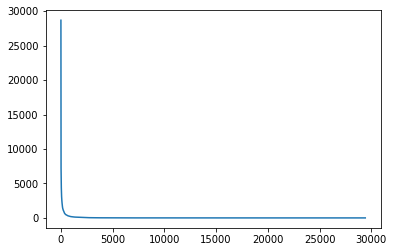

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

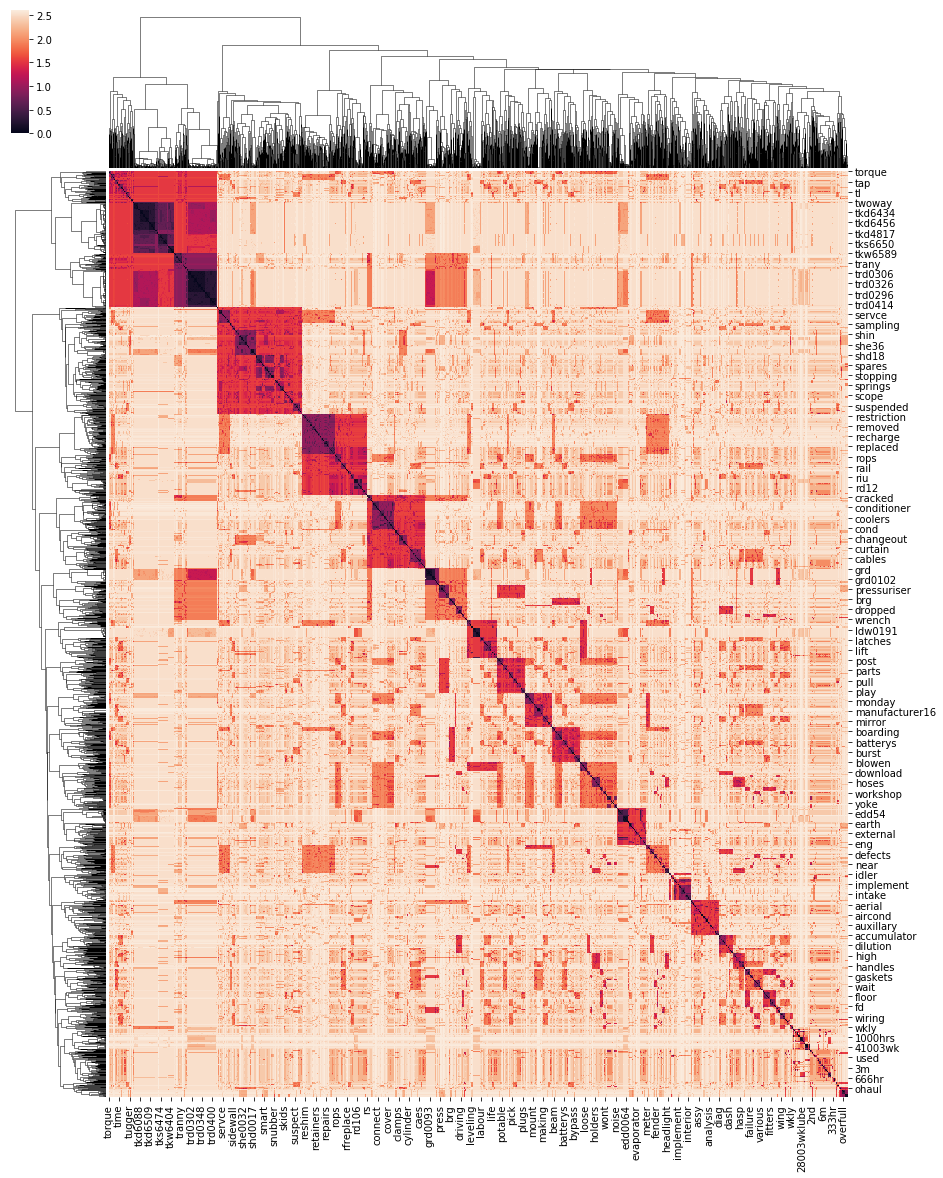

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()